In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Загрузка сохраненной модели
model_path = '/content/drive/MyDrive/colab_models/best_model_20250727_190636_2.keras'
model = load_model(model_path, compile=False)

# 2. Настройки данных (должны соответствовать обучению)
DATA_DIR = "/content/drive/MyDrive/product_images_500"
IMG_SIZE = (300, 300)
BATCH_SIZE = 32

# 3. Создание генератора для валидации (без аугментации)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

val_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 4. Получение истинных меток и предсказаний
y_true = val_generator.classes
y_pred = model.predict(val_generator)
n_classes = y_pred.shape[1]

# 5. Binarize the output для многоклассового ROC
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# 6. Вычисление ROC кривых для каждого класса
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 7. Вычисление micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



Found 2466 images belonging to 28 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 1576s 20s/step


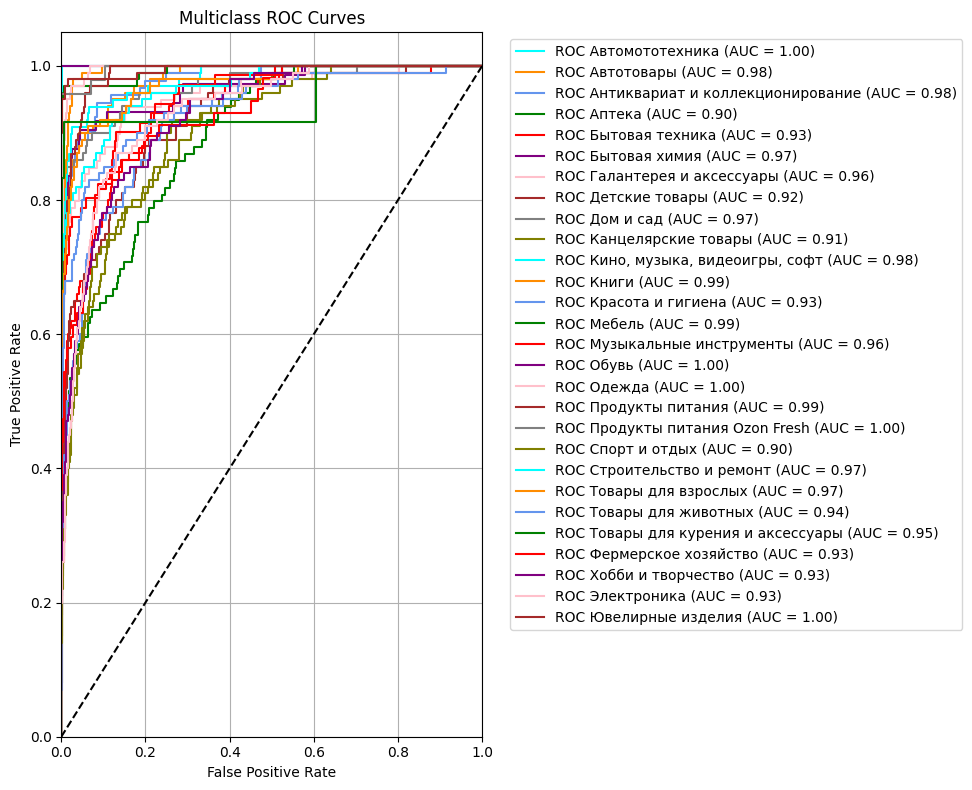

In [3]:

# Создаем обратное отображение индексов классов
class_indices_inv = {v: k for k, v in val_generator.class_indices.items()}

# 8. Визуализация ROC кривых (исправленная версия)
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                'purple', 'pink', 'brown', 'gray', 'olive'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC {0} (AUC = {1:0.2f})'
             ''.format(class_indices_inv[i], roc_auc[i]))


# Дальше идет оригинальный код построения графиков
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

In [4]:
# Вычисление и вывод общей ROC AUC
# Macro-average ROC AUC (не взвешенное среднее по классам)
all_auc = [roc_auc[i] for i in range(n_classes)]
macro_auc = np.mean(all_auc)

print("="*50)
print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
print(f"Macro-average ROC AUC: {macro_auc:.4f}")
print("="*50)

# Дополнительно: вывод AUC для каждого класса
print("\nAUC for each class:")
for i in range(n_classes):
    print(f"{class_indices_inv[i]}: {roc_auc[i]:.4f}")

Micro-average ROC AUC: 0.9666
Macro-average ROC AUC: 0.9592

AUC for each class:
Автомототехника: 0.9998
Автотовары: 0.9802
Антиквариат и коллекционирование: 0.9806
Аптека: 0.8953
Бытовая техника: 0.9317
Бытовая химия: 0.9673
Галантерея и аксессуары: 0.9564
Детские товары: 0.9244
Дом и сад: 0.9697
Канцелярские товары: 0.9080
Кино, музыка, видеоигры, софт: 0.9803
Книги: 0.9950
Красота и гигиена: 0.9264
Мебель: 0.9937
Музыкальные инструменты: 0.9557
Обувь: 1.0000
Одежда: 0.9956
Продукты питания: 0.9860
Продукты питания Ozon Fresh: 0.9963
Спорт и отдых: 0.9037
Строительство и ремонт: 0.9665
Товары для взрослых: 0.9716
Товары для животных: 0.9413
Товары для курения и аксессуары: 0.9485
Фермерское хозяйство: 0.9287
Хобби и творчество: 0.9271
Электроника: 0.9312
Ювелирные изделия: 0.9973


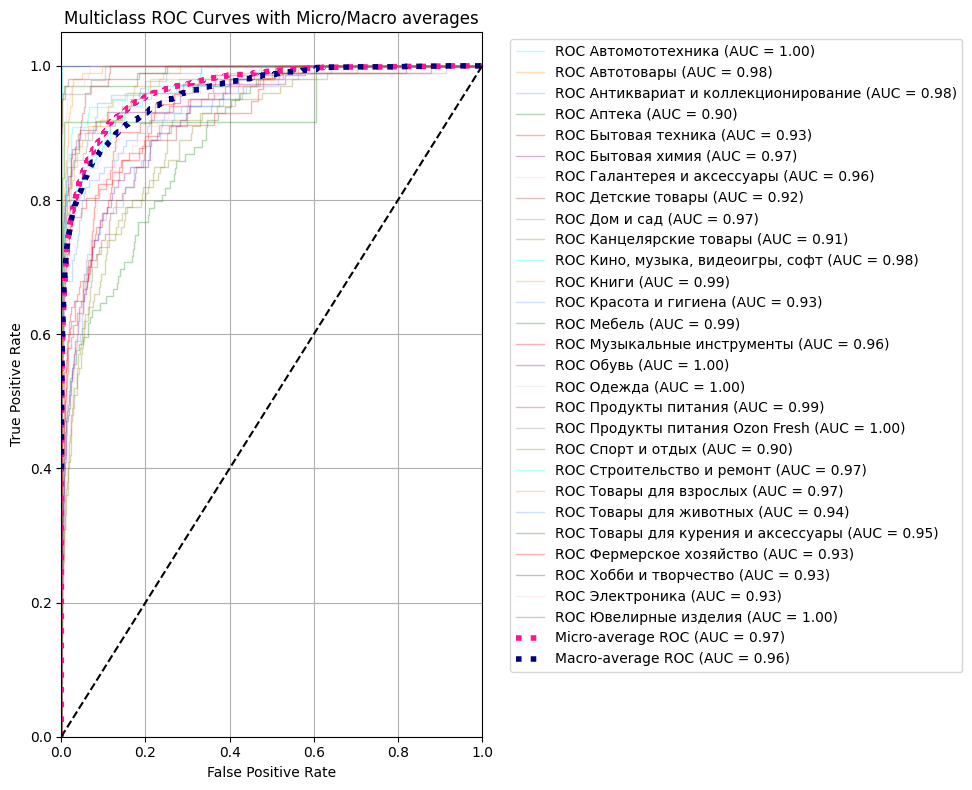

In [5]:
# Визуализация общей ROC AUC
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red',
                'purple', 'pink', 'brown', 'gray', 'olive'])

# 1. Кривые для каждого класса
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.3,
             label='ROC {0} (AUC = {1:0.2f})'
             ''.format(class_indices_inv[i], roc_auc[i]))

# 2. Micro-average кривая (общая)
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC (AUC = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

# 3. Macro-average кривая
# Сначала агрегируем все FPR
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Затем интерполируем все TPR на эти точки
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# И наконец усредняем
mean_tpr /= n_classes

# Вычисляем AUC
macro_auc = auc(all_fpr, mean_tpr)
plt.plot(all_fpr, mean_tpr,
         label='Macro-average ROC (AUC = {0:0.2f})'
               ''.format(macro_auc),
         color='navy', linestyle=':', linewidth=4)

# Диагональ и настройки графика
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves with Micro/Macro averages')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()